In [5]:
from sklearn import metrics
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict

from ephysvibe.trials.spikes import firing_rate
from ephysvibe.trials import align_trials

from ephysvibe.trials.spikes import firing_rate,sp_constants
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.structures.bhv_data import BhvData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants, task_constants2,task_constants3,def_task,def_task2,def_task3
import os 
from matplotlib import cm
import glob
import pickle
seed = 2023

In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [3]:
def scale_p(x, out_range=(-1, 1)):
    if np.sum(x>1) >0:
        return
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [10]:
print(["aa", a])

['aa', 5]


In [4]:
def compute_roc_auc(group1,group2):
    #roc_score:Dict[str,list] = defaultdict(list)
    # scaler = MinMaxScaler(feature_range=(-1,1))
    # scaler.fit(np.arange(0,1,0.1).reshape(-1, 1))
    rng = np.random.default_rng(seed=seed)
    #it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        # if n_win == 316:
        #     print(n_win)
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]
        # Wilcoxon rank-sum 
    
        p.append(stats.ttest_ind(g1, g2)[1])#stats.ttest_ind
        # min_fr, max_fr = np.concatenate([g1,g2]).min(),np.concatenate([g1,g2]).max()

        thresholds = np.unique(np.concatenate([g1,g2]))#np.arange(min_fr,max_fr+0.01,0.01)

        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            #idx_sort=fpr.argsort()
            score = metrics.auc(fpr[fpr.argsort()],tpr[fpr.argsort()])
        roc_score.append(score)
        # else:
        #     roc_score.append(score)
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2),out_range=[-1,1])#scaler.transform(np.round(roc_score,2).reshape(-1, 1)).squeeze()
    return roc_score,p


In [5]:
def get_mag_ang(data,bhv,i_neuron,in_out, date):
    t_before = 400
    t_after = 1200
    
    year    =   int(date[:4])
    month   =   int(date[5:7])
    day     =   int(date[8:10])

    trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
    if np.any(np.isnan(data.neuron_cond)):
            neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond = data.neuron_cond
            
    if year<2023:
        shifts = data.code_samples[
            trials_b1,
            np.where(data.code_numbers[trials_b1] == task_constants.EVENTS_B1["sample_on"])[
                1
            ],
        ]-t_before
        
        task = def_task.create_task_frame(
            condition=bhv.condition[trials_b1],
            test_stimuli=bhv.test_stimuli[trials_b1],
            samples_cond=task_constants.SAMPLES_COND,
            neuron_cond=neuron_cond,
            )      
    elif month<9:
        shifts = data.code_samples[
            trials_b1,
            np.where(data.code_numbers[trials_b1] == task_constants.EVENTS_B1["sample_on"])[
                1
            ],
        ]-t_before
        
        task = def_task.create_task_frame(
        condition=bhv.condition[trials_b1],
        test_stimuli=bhv.test_stimuli[trials_b1],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond=neuron_cond,
        )      
    elif month>=9 and month<11:        
        shifts = data.code_samples[
            trials_b1,
            np.where(data.code_numbers[trials_b1] == task_constants2.EVENTS_B1["sample_on"])[
                1
            ],
        ]-t_before
        
        task = def_task2.create_task_frame(
            condition=bhv.condition[trials_b1],
            test_stimuli=bhv.test_stimuli[trials_b1],
            samples_cond=task_constants2.SAMPLES_COND,
            neuron_cond=neuron_cond,
            )      
 
    elif month>=11:        
        shifts = data.code_samples[
            trials_b1,
            np.where(data.code_numbers[trials_b1] == task_constants3.EVENTS_B1["sample_on"])[
                1
            ],
        ]-t_before

        
        task = def_task3.create_task_frame(
            condition=bhv.condition[trials_b1],
            test_stimuli=bhv.test_stimuli[trials_b1],
            samples_cond=task_constants3.SAMPLES_COND,
            neuron_cond=neuron_cond,
            )     
        
    roll_sp = SpikeData.indep_roll(data.sp_samples[trials_b1,i_neuron], shifts=-shifts.astype(int), axis=1)[:,:t_after+t_before]
    
    task = task[(task['i_neuron']==i_neuron)&(task['in_out']==in_out)]

    o1_c1_trials = task[task['sample']=='o1_c1']['trial_idx'].values
    o1_c5_trials = task[task['sample']=='o1_c5']['trial_idx'].values
    o5_c1_trials = task[task['sample']=='o5_c1']['trial_idx'].values
    o5_c5_trials = task[task['sample']=='o5_c5']['trial_idx'].values
    o0_c0_trials = task[task['sample']=='o0_c0']['trial_idx'].values

    win = 100
    step = 1
    min_n_tr = np.min([len(o1_c1_trials),len(o1_c5_trials),len(o5_c1_trials),len(o5_c5_trials)])
    if min_n_tr < 3:
        nan_array = np.full(t_after+t_before-win,np.nan)
        return nan_array,nan_array,nan_array,nan_array,nan_array,nan_array,nan_array,nan_array,nan_array,nan_array
    # rng = np.random.default_rng(seed=seed)
    # o1_c1_trials = rng.choice(o1_c1_trials, size=min_n_tr, replace=False)
    # o1_c5_trials = rng.choice(o1_c5_trials, size=min_n_tr, replace=False)
    # o5_c1_trials = rng.choice(o5_c1_trials, size=min_n_tr, replace=False)
    # o5_c5_trials = rng.choice(o5_c5_trials, size=min_n_tr, replace=False)

    avg_sp = moving_average(data=roll_sp,win=win, step=step)[:,:-win]

    c1_sp = avg_sp[np.concatenate([o1_c1_trials,o5_c1_trials])] 
    c5_sp = avg_sp[np.concatenate([o5_c5_trials,o1_c5_trials])] 
    o1_sp = avg_sp[np.concatenate([o1_c1_trials,o1_c5_trials])] 
    o5_sp = avg_sp[np.concatenate([o5_c1_trials,o5_c5_trials])] 
     
    
    non_neutral_sp  =   avg_sp[np.concatenate([o1_c1_trials,o1_c5_trials,o5_c1_trials,o5_c5_trials])]
    neutral_sp      =   avg_sp[o0_c0_trials]
    
    color,p_color = compute_roc_auc(c1_sp,c5_sp)
    orient,p_orient = compute_roc_auc(o1_sp,o5_sp)
    sample_neutral, p_sample_neutral    =   compute_roc_auc(neutral_sp, non_neutral_sp)
    
    x = color
    y = orient
    mag = np.sqrt(x**2+y**2)
    ang = np.arctan2(y,x)*180/np.pi
    ang = np.where(ang >=0,ang,ang+360)

    return mag,ang,orient,color,sample_neutral,p_orient, p_color, p_sample_neutral, o1_sp,o5_sp, c1_sp,c5_sp,non_neutral_sp,neutral_sp

In [6]:
def definelatencies(p_orient, p_color, p_neutral, win, threshold):
# p_orient=all_lip_orient_p
# p_color=all_lip_color_p
# p_neutral=all_lip_neutral_p
# step=1
# win=75
# threshold=75
   latorient=[]
   latcolor=[]
   latneutral=[]

   for i in np.arange(p_color.shape[0]):
      
      tmpO=[]
      tmpC=[]
      tmpN=[]

      sigO=np.zeros(p_orient.shape[1])
      sigO[np.where(p_orient[i,:]<0.01)]=1
      

      sigC=np.zeros(p_color.shape[1])
      sigC[np.where(p_color[i,:]<0.01)]=1
      
      sigN=np.zeros(p_neutral.shape[1])
      sigN[np.where(p_neutral[i,:]<0.01)]=1

      for i_step in np.arange(sigO.shape[0]):
         if sigO[i_step]==1 and np.sum(sigO[i_step:i_step+win])>=threshold:
            tmpO.append(i_step)  
      
         if sigC[i_step]==1 and np.sum(sigC[i_step:i_step+win])>=threshold:
            tmpC.append(i_step) 
         
         if sigN[i_step]==1 and np.sum(sigN[i_step:i_step+win])>=threshold:
            tmpN.append(i_step) 
      
      if not tmpO:
         latorient.append(np.nan)  
      else:
         latorient.append(tmpO[0])  
      
      if not tmpC:
         latcolor.append(np.nan)  
      else:
         latcolor.append(tmpC[0]) 

      if not tmpN:
         latneutral.append(np.nan)  
      else:
         latneutral.append(tmpN[0])  

   latorient=np.array(latorient)
   latcolor=np.array(latcolor)
   latneutral=np.array(latneutral)

   return latorient, latcolor, latneutral


In [7]:
directory_b1    =   "W:/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/"
bhv_directory   =   os.path.normpath(str(directory_b1) +  "/bhv/")

area="pfc"
spike_pfc_directory =   os.path.normpath(str(directory_b1) + area + "/spikes/*.h5")
spike_pfc_files     =   glob.glob(spike_pfc_directory, recursive=True)

area="v4"
spike_v4_directory =   os.path.normpath(str(directory_b1) + area + "/spikes/*.h5")
spike_v4_files     =   glob.glob(spike_v4_directory, recursive=True)

area="lip"
spike_lip_directory =   os.path.normpath(str(directory_b1) + area + "/spikes/*.h5")
spike_lip_files     =   glob.glob(spike_lip_directory, recursive=True)

In [57]:
## pfc
all_pfc_mag,all_pfc_ang=[],[]
all_pfc_orient_value, all_pfc_color_value, all_pfc_neutral_value=[],[],[]
all_pfc_orient_p,all_pfc_color_p,all_pfc_neutral_p=[],[],[]
all_o1_pfc_sp, all_o5_pfc_sp, all_c1_pfc_sp, all_c5_pfc_sp=[],[],[],[]
pfc_neuron=[]

paths=spike_pfc_files
for p in paths:
    
    s_path = str(p).split(os.sep)[-1]
    date    =   s_path[:19]
    index   =   s_path.find('g_')
    path_bhv=os.path.normpath(str(bhv_directory) + "/" + str(s_path[:index]) + "g_e1_r1_bhv.h5")
    data = SpikeData.from_python_hdf5(str(p))
    bhv = BhvData.from_python_hdf5(path_bhv)
    s_path = os.path.normpath(p).split(os.sep)
    
    i_good, i_mua = 1, 1
    for i_neuron,cluster in enumerate(data.clustersgroup):


        if cluster == "good":
            i_cluster = i_good
            i_good += 1
            cluster = "neuron"

        else:
            i_cluster = i_mua
            i_mua += 1

        in_out = "in"

        mag, ang, orient, color, sample_neutral, p_orient, p_color, p_sample_neutral, o1_sp, o5_sp, c1_sp,c5_sp,non_neutral_sp,neutral_sp  = get_mag_ang(data,bhv,i_neuron,in_out, date)
        
        all_pfc_mag.append(mag)
        all_pfc_ang.append(ang)

        all_pfc_orient_value.append(orient)
        all_pfc_color_value.append(color)
        all_pfc_neutral_value.append(sample_neutral)

        all_pfc_orient_p.append(p_orient)
        all_pfc_color_p.append(p_color)
        all_pfc_neutral_p.append(p_sample_neutral)

        all_o1_pfc_sp.append(o1_sp)
        all_o5_pfc_sp.append(o5_sp)
        all_c1_pfc_sp.append(c1_sp)
        all_c5_pfc_sp.append(c5_sp)
        
        pfc_neuron.append(cluster+str(i_cluster)+'_'+s_path[-1][:-25])

all_pfc_mag             =   np.array(all_pfc_mag)     
all_pfc_ang             =   np.array(all_pfc_ang)     
all_pfc_orient_value    =   np.array(all_pfc_orient_value) 
all_pfc_color_value     =   np.array(all_pfc_color_value) 
all_pfc_neutral_value   =   np.array(all_pfc_neutral_value) 
all_pfc_orient_p        =   np.array(all_pfc_orient_p) 
all_pfc_orient_p        =   np.array(all_pfc_orient_p) 
all_pfc_color_p         =   np.array(all_pfc_color_p) 
all_pfc_neutral_p       =   np.array(all_pfc_neutral_p) 

lat_pfc_orient, lat_pfc_color, lat_pfc_neutral  =   definelatencies(all_pfc_orient_p, all_pfc_color_p, all_pfc_neutral_p, win=75, threshold=75):

pfc_sample_ROC_values   =   ["ROC value neutral", all_pfc_neutral_value, "ROC value orient", all_pfc_orient_value, "ROC value color", all_pfc_color_value]
pfc_sample_ROC_p        =   ["p value neutral", all_pfc_neutral_p, "p value orient", all_pfc_orient_p, "p value color", all_pfc_color_p]
pfc_sample_latencies    =   ["Neutral lat", lat_pfc_neutral, "orient lat", lat_pfc_orient, "color lat", lat_pfc_orient, ]

pfc_sampe_ROC_analyses=[pfc_sample_ROC_values, pfc_sample_ROC_p, pfc_sample_latencies]
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/pfcsampleROC", "wb") as fp: 
    pickle.dump(pfc_sampe_ROC_analyses, fp)

In [17]:
## v4
all_v4_mag,all_v4_ang=[],[]
all_v4_orient_value, all_v4_color_value, all_v4_neutral_value=[],[],[]
all_v4_orient_p,all_v4_color_p,all_v4_neutral_p=[],[],[]
all_o1_v4_sp, all_o5_v4_sp, all_c1_v4_sp, all_c5_v4_sp=[],[],[],[]
v4_neuron=[]

paths=spike_v4_files
for p in paths:
    
    s_path = str(p).split(os.sep)[-1]
    date    =   s_path[:19]
    index   =   s_path.find('g_')
    path_bhv=os.path.normpath(str(bhv_directory) + "/" + str(s_path[:index]) + "g_e1_r1_bhv.h5")
    data = SpikeData.from_python_hdf5(str(p))
    bhv = BhvData.from_python_hdf5(path_bhv)
    s_path = os.path.normpath(p).split(os.sep)
    
    i_good, i_mua = 1, 1
    
    for i_neuron,cluster in enumerate(data.clustersgroup):
        if cluster == "good":
            i_cluster = i_good
            i_good += 1
            cluster = "neuron"

        else:
            i_cluster = i_mua
            i_mua += 1

        in_out = "in"
        
        mag, ang, orient, color, sample_neutral, p_orient, p_color, p_sample_neutral, o1_sp, o5_sp, c1_sp,c5_sp,non_neutral_sp,neutral_sp  = get_mag_ang(data,bhv,i_neuron,in_out, date)
        
        all_v4_mag.append(mag)
        all_v4_ang.append(ang)

        all_v4_orient_value.append(orient)
        all_v4_color_value.append(color)
        all_v4_neutral_value.append(sample_neutral)
        
        all_v4_orient_p.append(p_orient)
        all_v4_color_p.append(p_color)
        all_v4_neutral_p.append(p_sample_neutral)

        all_o1_v4_sp.append(o1_sp)
        all_o5_v4_sp.append(o5_sp)
        all_c1_v4_sp.append(c1_sp)
        all_c5_v4_sp.append(c5_sp)
        
        v4_neuron.append(cluster+str(i_cluster)+'_'+s_path[-1][:-25])

all_v4_mag     =   np.array(all_v4_mag)     
all_v4_ang     =   np.array(all_v4_ang)     
all_v4_orient_value   =   np.array(all_v4_orient_value) 
all_v4_color_value  =   np.array(all_v4_color_value) 
all_v4_neutral_value =   np.array(all_v4_neutral_value) 
all_v4_orient_p=   np.array(all_v4_orient_p) 
all_v4_orient_p   = np.array(all_v4_orient_p) 
all_v4_color_p   = np.array(all_v4_color_p) 
all_v4_neutral_p   = np.array(all_v4_neutral_p) 

lat_v4_orient, lat_v4_color, lat_v4_neutral  =   definelatencies(all_v4_orient_p, all_v4_color_p, all_v4_neutral_p, win=75, threshold=75):

v4_sample_ROC_values   =   ["ROC value neutral", all_v4_neutral_value, "ROC value orient", all_v4_orient_value, "ROC value color", all_v4_color_value]
v4_sample_ROC_p        =   ["p value neutral", all_v4_neutral_p, "p value orient", all_v4_orient_p, "p value color", all_v4_color_p]
v4_sample_latencies    =   ["Neutral lat", lat_v4_neutral, "orient lat", lat_v4_orient, "color lat", lat_v4_orient, ]

v4_sampe_ROC_analyses=[v4_sample_ROC_values, v4_sample_ROC_p, v4_sample_latencies]
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/v4sampleROC", "wb") as fp: 
    pickle.dump(v4_sampe_ROC_analyses, fp)

In [66]:
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/lipsampleROC", "rb") as fp:   # Unpickling
    b = pickle.load(fp)

0.0

In [8]:
## lip
all_lip_mag,all_lip_ang=[],[]
all_lip_orient_value, all_lip_color_value, all_lip_neutral_value=[],[],[]
all_lip_orient_p,all_lip_color_p,all_lip_neutral_p=[],[],[]
all_o1_lip_sp, all_o5_lip_sp, all_c1_lip_sp, all_c5_lip_sp=[],[],[],[]
lip_neuron=[]

paths=spike_lip_files

for p in paths:
    
    s_path = str(p).split(os.sep)[-1]
    date    =   s_path[:19]
    index   =   s_path.find('g_')
    path_bhv=os.path.normpath(str(bhv_directory) + "/" + str(s_path[:index]) + "g_e1_r1_bhv.h5")
    data = SpikeData.from_python_hdf5(str(p))
    bhv = BhvData.from_python_hdf5(path_bhv)
    s_path = os.path.normpath(p).split(os.sep)
    
    i_good, i_mua = 1, 1
    
    for i_neuron,cluster in enumerate(data.clustersgroup):

        if cluster == "good":
            i_cluster = i_good
            i_good += 1
            cluster = "neuron"

        else:
            i_cluster = i_mua
            i_mua += 1
        
        in_out = "in"
        mag, ang, orient, color, sample_neutral, p_orient, p_color, p_sample_neutral, o1_sp, o5_sp, c1_sp,c5_sp,non_neutral_sp,neutral_sp  = get_mag_ang(data,bhv,i_neuron,in_out, date)
        
        all_lip_mag.append(mag)
        all_lip_ang.append(ang)

        all_lip_orient_value.append(orient)
        all_lip_color_value.append(color)
        all_lip_neutral_value.append(sample_neutral)
  
        all_lip_orient_p.append(p_orient)
        all_lip_color_p.append(p_color)
        all_lip_neutral_p.append(p_sample_neutral)

        all_o1_lip_sp.append(o1_sp)
        all_o5_lip_sp.append(o5_sp)
        all_c1_lip_sp.append(c1_sp)
        all_c5_lip_sp.append(c5_sp)
        
        lip_neuron.append(cluster+str(i_cluster)+'_'+s_path[-1][:-25])

all_lip_mag     =   np.array(all_lip_mag)     
all_lip_ang     =   np.array(all_lip_ang)     
all_lip_orient_value   =   np.array(all_lip_orient_value) 
all_lip_color_value  =   np.array(all_lip_color_value) 
all_lip_neutral_value =   np.array(all_lip_neutral_value) 
all_lip_orient_p=   np.array(all_lip_orient_p) 
all_lip_color_p   = np.array(all_lip_color_p) 
all_lip_neutral_p   = np.array(all_lip_neutral_p) 

lat_lip_orient, lat_lip_color, lat_lip_neutral  =   definelatencies(all_lip_orient_p, all_lip_color_p, all_lip_neutral_p, win=75, threshold=75)

lip_sample_ROC_values   =   ["ROC value neutral", all_lip_neutral_value, "ROC value orient", all_lip_orient_value, "ROC value color", all_lip_color_value]
lip_sample_ROC_p        =   ["p value neutral", all_lip_neutral_p, "p value orient", all_lip_orient_p, "p value color", all_lip_color_p]
lip_sample_latencies    =   ["Neutral lat", lat_lip_neutral, "orient lat", lat_lip_orient, "color lat", lat_lip_orient, ]

lip_sampe_ROC_analyses=[lip_sample_ROC_values, lip_sample_ROC_p, lip_sample_latencies]
with open("C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/ROCanalayses/LIPsampleROC", "wb") as fp: 
    pickle.dump(lip_sampe_ROC_analyses, fp)


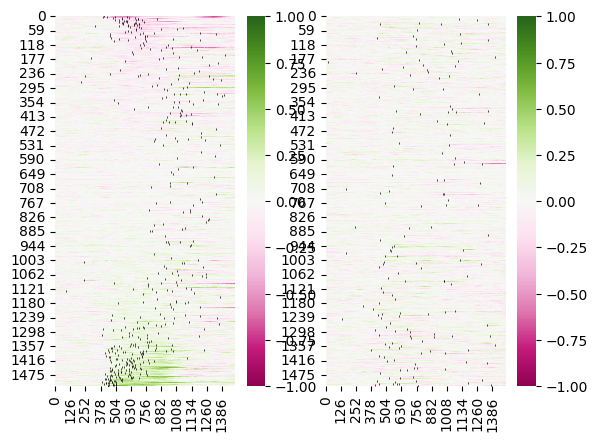

In [163]:
# plot pfc

sort_neutral    =   np.argsort(np.mean(all_pfc_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_pfc_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_pfc_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_pfc_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_pfc_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_pfc_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_pfc_neutral[sort_neutral], np.arange(lat_pfc_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_pfc_orient[sort_orient], np.arange(lat_pfc_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_pfc_color[sort_color], np.arange(lat_pfc_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_pfc.pdf')  


In [ ]:
# plot v4

sort_neutral    =   np.argsort(np.mean(all_v4_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_v4_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_v4_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_v4_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_v4_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_v4_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_v4_neutral[sort_neutral], np.arange(lat_v4_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_v4_orient[sort_orient], np.arange(lat_v4_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_v4_color[sort_color], np.arange(lat_v4_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_v4.pdf')  


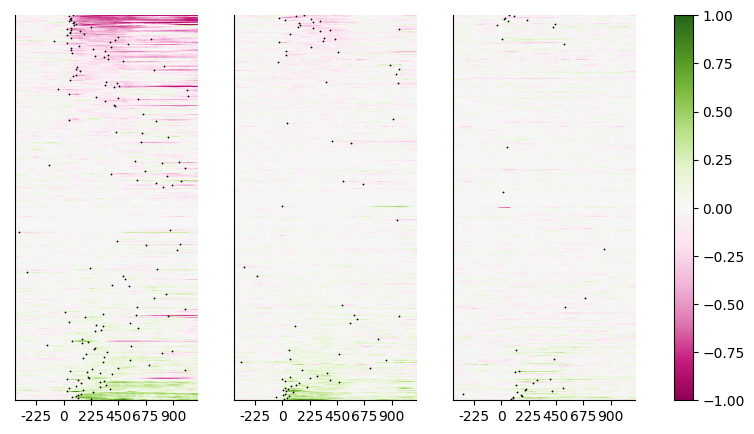

In [23]:
# plot LIP

sort_neutral    =   np.argsort(np.mean(all_lip_neutral_value[:,450:900], axis=1))
sort_orient     =   np.argsort(np.mean(all_lip_orient_value[:,450:900], axis=1))
sort_color      =   np.argsort(np.mean(all_lip_color_value[:,450:900], axis=1))

# fig     =   plt.figure(figsize=(10,10))
fig, ax      =   plt.subplots(1,3,figsize=(10,5))
im0       =   ax[0].imshow(all_lip_neutral_value[sort_neutral,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im1       =   ax[1].imshow(all_lip_orient_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')
im2       =   ax[2].imshow(all_lip_color_value[sort_orient,:], vmin=-1, vmax=1, cmap='PiYG', aspect='auto')

ax[0].scatter(lat_lip_neutral[sort_neutral], np.arange(lat_lip_neutral.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[1].scatter(lat_lip_orient[sort_orient], np.arange(lat_lip_orient.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)
ax[2].scatter(lat_lip_color[sort_color], np.arange(lat_lip_color.shape[0])-0.5, marker ='o', color=[0, 0, 0], linewidths=0.2,s=1)

# ax[0].x    ([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)], labels=['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[0].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[0].set_yticks([])
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
ax[1].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[1].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[1].set_yticks([])
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[2].set_xticks([400+225*(-1), 400+225*(0), 400+225*(1), 400+225*(2), 400+225*(3), 400+225*(4)])#, ['-225', '0', '225', '450', '675', '900'])
ax[2].set_xticklabels(['-225', '0', '225', '450', '675', '900'])
ax[2].set_yticks([])
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
fig.colorbar(im2, ax=ax)


plt.savefig('C:/Users/ibos.g/Documents/Data/INT-Marseille/OpenEphys/Riesling/figures/ROC_lip.pdf')  


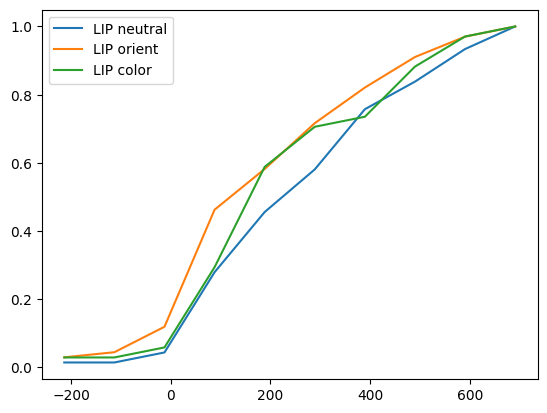

In [25]:

count_lip_neutral, bins_count = np.histogram(lat_lip_neutral[np.logical_and(lat_lip_neutral>0, lat_lip_neutral< 1200)], bins=10) 
pdf_lip_neutral = count_lip_neutral / sum(count_lip_neutral) 
cdf_lip_neutral = np.cumsum(pdf_lip_neutral) 

count_lip_orient, bins_count = np.histogram(lat_lip_orient[np.logical_and(lat_lip_orient>0, lat_lip_orient< 1200)], bins=10) 
pdf_lip_orient = count_lip_orient / sum(count_lip_orient) 
cdf_lip_orient = np.cumsum(pdf_lip_orient) 

count_lip_color, bins_count = np.histogram(lat_lip_color[np.logical_and(lat_lip_color>0, lat_lip_color< 1200)], bins=10) 
pdf_lip_color = count_lip_color / sum(count_lip_color) 
cdf_lip_color = np.cumsum(pdf_lip_color) 

plt.plot(bins_count[1:]-400, cdf_lip_neutral, label="LIP neutral") 
plt.plot(bins_count[1:]-400, cdf_lip_orient, label="LIP orient") 
plt.plot(bins_count[1:]-400, cdf_lip_color, label="LIP color") 
plt.legend() 

In [ ]:
def scale_mag(x, out_range=(0.05, 1)):
    domain = 0.2, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [ ]:
quant_steps=360*4
cmap=cm.get_cmap('hsv',quant_steps)

f_all_mag=np.where(np.array(all_mag)>1,1.,np.array(all_mag))
lim = 0.2
mask=f_all_mag<lim
f_all_mag = scale_mag(f_all_mag)
f_all_mag = np.where(f_all_mag<0,0,f_all_mag)
f_all_mag = np.where(np.isnan(f_all_mag),0,f_all_mag)

In [47]:
def find_significant(p_value:np.ndarray,win:int, step:int=1)-> np.ndarray:

    p_shape=p_value.shape
    sign = np.zeros((p_shape[0],int(np.floor(p_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,p_shape[1]-step,step):
        sign[:,count] = np.where(np.all(p_value[:,i_step:i_step+win]<0.05,axis=1),True,False)
        #sign[:,count] = np.where((np.sum(p_color_all[:,i_step:i_step+win]<0.01,axis=1)>=30),True,False)
        count +=1
    return sign

In [36]:
step=1
win=50
s_color = find_significant(p_value=p_color_all,win=win, step=step)
s_orient = find_significant(p_value=p_orient_all,win=win, step=step)
s_color.shape

(1520, 1500)

In [67]:
lat=np.nan(p_orient_all.shape[0])

TypeError: 'float' object is not callable

In [92]:
lat=[]
for j in range(p_orient_all.shape[0]):
    sig=np.where(s_orient[j,:]==1)
    if not sig[0]:
        lat.append(np.nan)
    else:
        lat.append(sig[0][0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [91]:
sig[0]

array([1210, 1211, 1212, 1213, 1214, 1215, 1216], dtype=int64)

In [81]:
sig[0][0]

1210

In [39]:
step=1
win=50
s_color = find_significant(p_value=p_color_all,win=win, step=step)
s_orient = find_significant(p_value=p_orient_all,win=win, step=step)

no_sig = np.where(np.sum(s_orient,axis=1)==0)[0]
if len(no_sig)!=0:
    s_orient[no_sig,-1]=np.nan
no_sig = np.where(np.sum(s_color,axis=1)==0)[0]
if len(no_sig)!=0:
    s_color[no_sig,-1]=np.nan

orient_max = np.nanargmax(s_orient,axis=1)
orient_max = np.where(np.logical_and(orient_max==0,np.isnan(s_orient[:,-1])),np.nan,orient_max)
color_max = np.nanargmax(s_color,axis=1)
color_max = np.where(np.logical_and(color_max==0,np.isnan(s_color[:,-1])),np.nan,color_max)